In [1]:
import numpy as np
import pandas as pd 
import os

In [6]:
main_dir = '/kaggle/input/uw-madison-gi-tract-image-segmentation'
train_folder = os.path.join(main_dir, 'train')
test_folder = os.path.join(main_dir, 'test')



In [7]:
train_df = pd.read_csv(os.path.join(main_dir, 'train.csv'))
train_df.head()

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


In [8]:
print(len(train_df))

115488


In [9]:
train_df.segmentation.isna().sum()

81575

In [10]:
classes = train_df.loc[:, 'class'].unique().tolist()
classes

['large_bowel', 'small_bowel', 'stomach']

In [11]:
for cl in classes:
    print('{}: {}'.format(cl, len(train_df[train_df['class'] == cl])))



large_bowel: 38496
small_bowel: 38496
stomach: 38496


In [12]:
train_df_grouped = train_df.copy()
train_df_grouped.set_index('id', inplace = True)



In [13]:
seg_list = []
for cl in classes:
    seg = train_df_grouped[train_df_grouped['class'] == cl]['segmentation']
    seg.name = cl
    seg_list.append(seg)
    
train_df_grouped = pd.concat(seg_list, axis=1).reset_index()
train_df_grouped.fillna('', inplace = True)
train_df_grouped.head()

,id,large_bowel,small_bowel,stomach
0,case123_day20_slice_0001,,,
1,case123_day20_slice_0002,,,
2,case123_day20_slice_0003,,,
3,case123_day20_slice_0004,,,
4,case123_day20_slice_0005,,,


In [14]:
def get_case_day_slice(x):
    
    #--------------------------------------------------------------------------------------
    # function that parses a string (full_path or image_id)
    # and returns case, day, slice_ 
    #--------------------------------------------------------------------------------------
    
    case = re.search('case[0-9]+', x).group()[len('case'):]
    day = re.search('day[0-9]+', x).group()[len('day'):]
    slice_ = re.search('slice_[0-9]+', x).group()[len('slice_'):]
    return case, day, slice_

In [15]:
from glob import glob
import re

case_day_slice = ['case', 'day', 'slice_']

def process_df(df, path):
    
    df = df.copy()
    df.loc[:, case_day_slice] = df.id.apply(get_case_day_slice).to_list()
    
    # get list of all images 
    all_images = glob(os.path.join(path, "**", "*.png"), recursive = True)
    img_df = pd.DataFrame(all_images, columns = ['full_path'])
    img_df.loc[:, case_day_slice] = img_df.full_path.apply(get_case_day_slice).to_list()
    
    return df.merge(img_df, on = case_day_slice, how = 'left')


In [16]:


train_df_grouped = process_df(train_df_grouped, train_folder)
train_df_grouped.head()



,id,large_bowel,small_bowel,stomach,case,day,slice_,full_path
0,case123_day20_slice_0001,,,,123,20,0001,/kaggle/input/uw-madison-gi-tract-image-segmen...
1,case123_day20_slice_0002,,,,123,20,0002,/kaggle/input/uw-madison-gi-tract-image-segmen...
2,case123_day20_slice_0003,,,,123,20,0003,/kaggle/input/uw-madison-gi-tract-image-segmen...
3,case123_day20_slice_0004,,,,123,20,0004,/kaggle/input/uw-madison-gi-tract-image-segmen...
4,case123_day20_slice_0005,,,,123,20,0005,/kaggle/input/uw-madison-gi-tract-image-segmen...


In [17]:
train_df_grouped = train_df_grouped[(train_df_grouped['case'] != 7) | (train_df_grouped['day'] != 0)].reset_index(drop = True)
train_df_grouped = train_df_grouped[(train_df_grouped['case'] != 81) | (train_df_grouped['day'] != 30)].reset_index(drop = True)


In [18]:

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

In [19]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

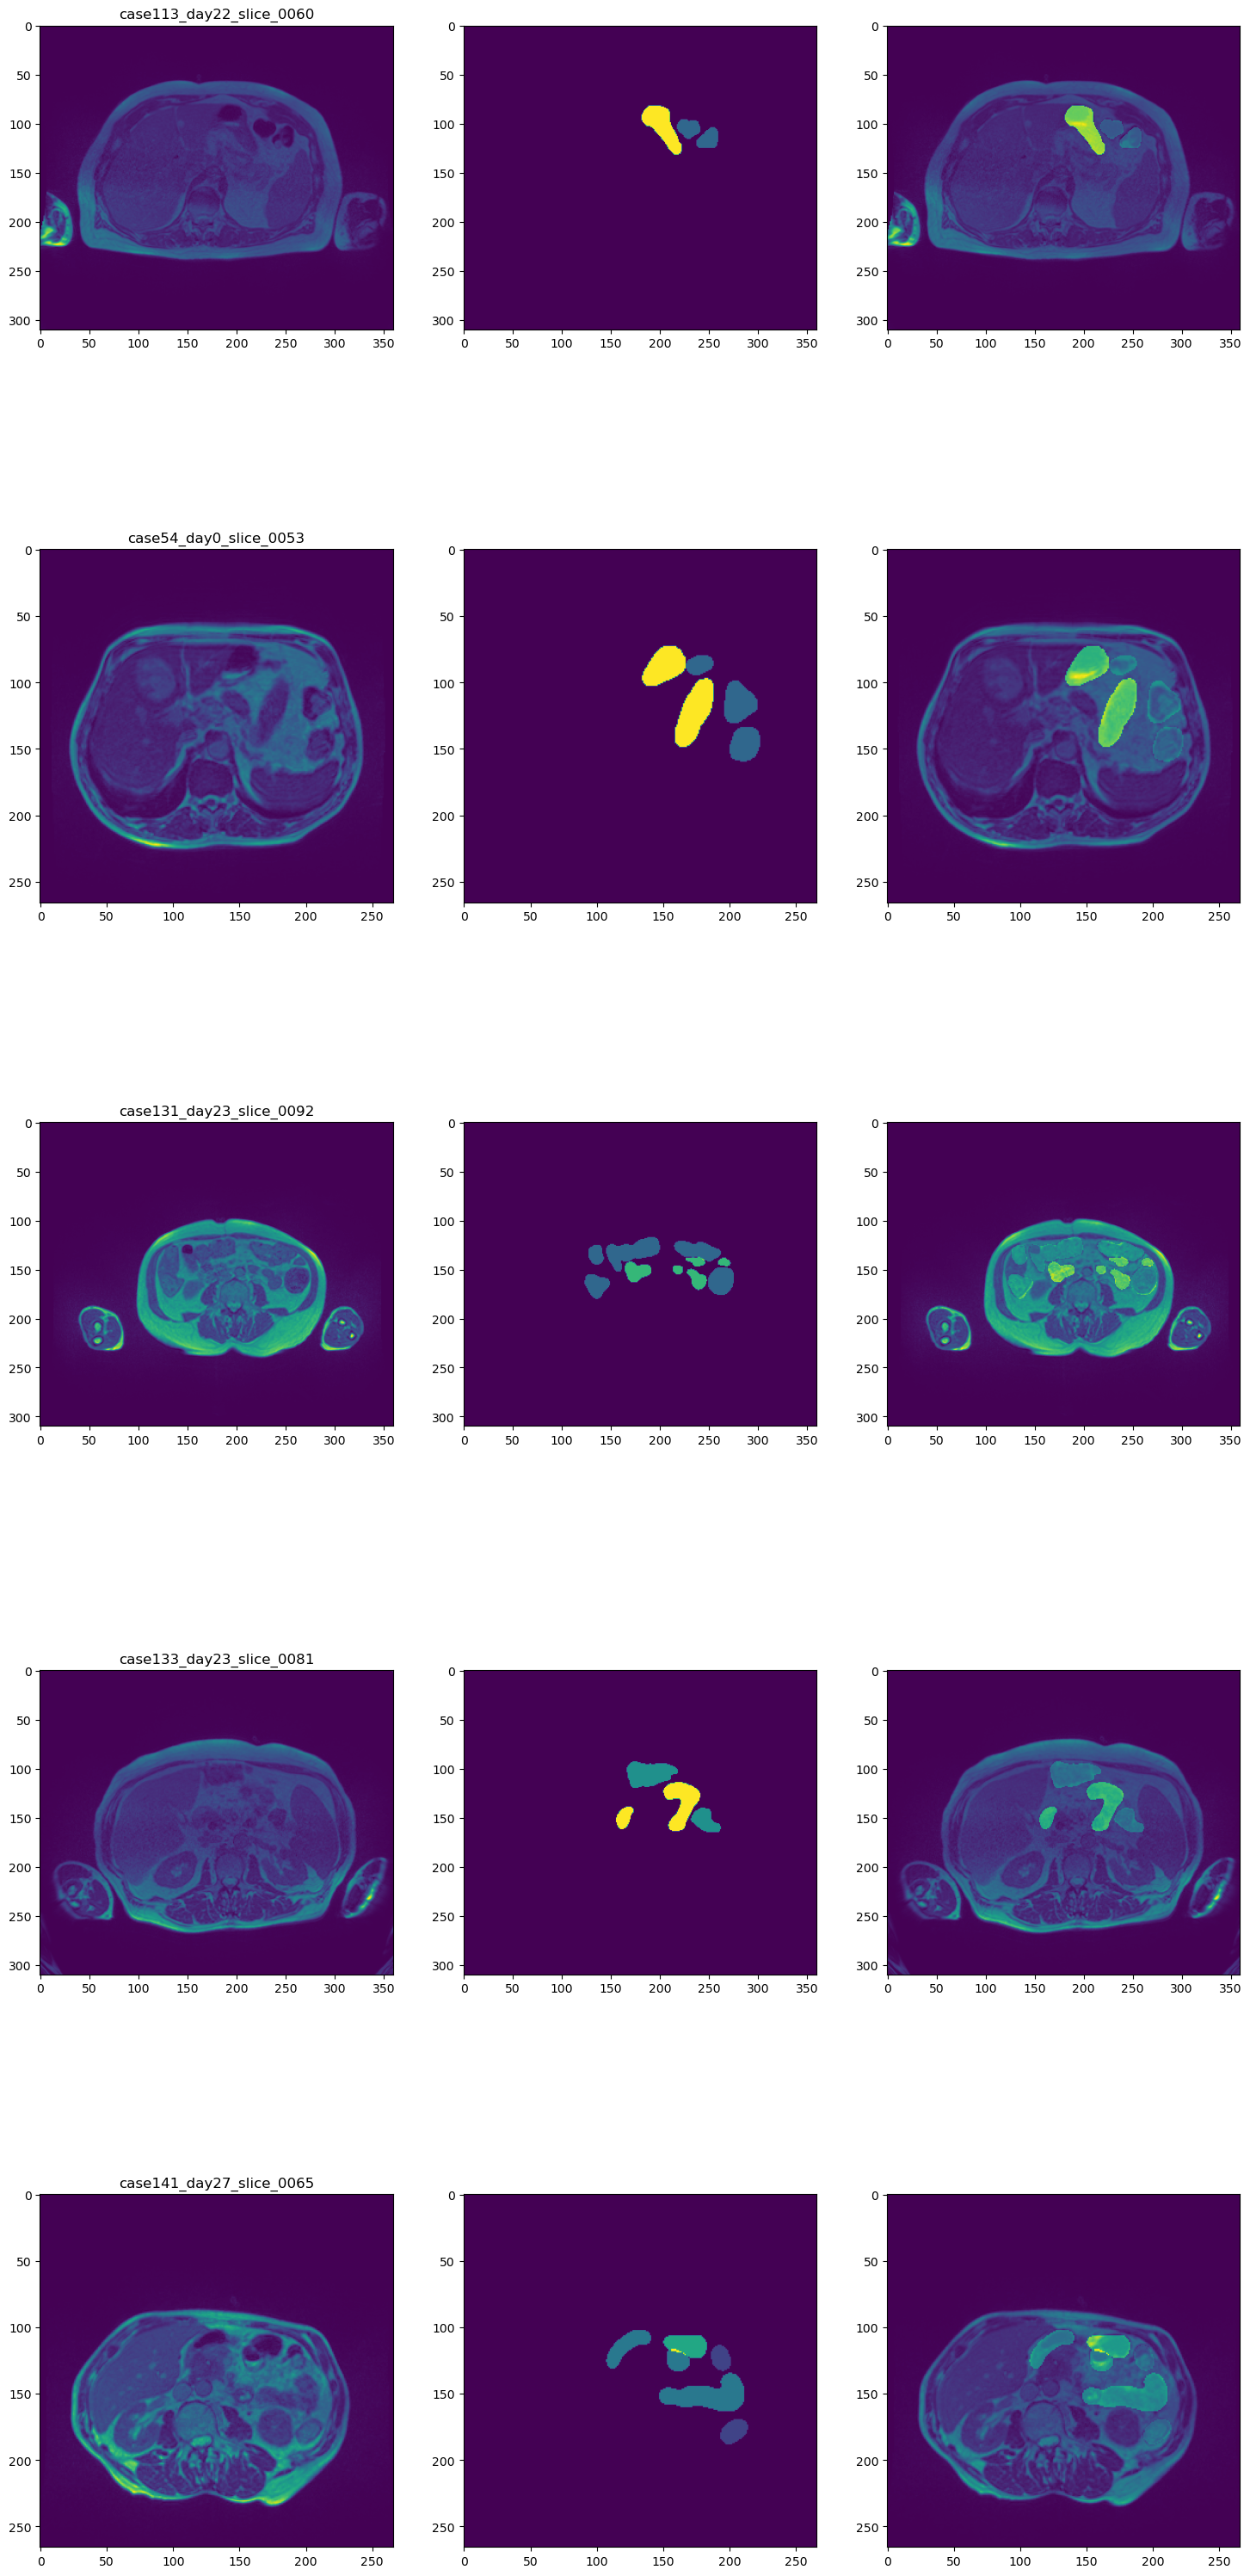

In [20]:
num = 5
segmentation_df_example = train_df_grouped[train_df_grouped.large_bowel != ''].sample(num)

fig, ax = plt.subplots(num, 3, figsize=(18, 8*num))
for i in range(num):
    record = segmentation_df_example.iloc[i, :]
    
    img = mpimg.imread(record.full_path, format = 'png')
    ax[i, 0].imshow(img)
    ax[i, 0].set_title(record.id)
    
    mask = np.zeros(img.shape)
    for j, cl in enumerate(classes):
        mask += rle_decode(record[cl], img.shape)*(j + 1) / 4 * np.max(img)
    ax[i, 1].imshow(mask)
    
    ax[i, 2].imshow(img + mask)



In [21]:
from enum import Enum, auto

class GeneratorMode(Enum):
    TRAIN = auto()
    TEST = auto()

In [22]:
import tensorflow as tf
img_size = 160

class ImageDataGen(tf.keras.utils.Sequence):
    
    def __init__(self,
                 df,
                 batch_size,
                 mode = GeneratorMode.TRAIN):

        self.df = df
        self.batch_size = batch_size
        self.image_size = img_size
        self.mode = mode
        
        self.len = len(df)
        
    def __getitem__(self, index):
        
        start, end = index * self.batch_size, (index + 1) * self.batch_size
        
        images = np.zeros((self.batch_size, self.image_size, self.image_size, 1))
        masks = np.zeros((self.batch_size, self.image_size, self.image_size, len(classes)))
        for i , pos in enumerate(range(start, end)):
            row = self.df.iloc[pos, :]
            
            #image
            image = tf.keras.preprocessing.image.load_img(row['full_path'], color_mode = "grayscale")
            image = tf.keras.preprocessing.image.img_to_array(image)
            image_shape = image.shape
            
            image = tf.image.resize(image, (self.image_size, self.image_size), method = 'nearest').numpy()
            image = image.reshape((self.image_size, self.image_size))
            images[i, :, :, 0] = image / 255.
            
            # masks (only train/val mode)
            if self.mode == GeneratorMode.TRAIN:
                for j, cl in enumerate(classes):
                    feat = row[cl]
                    mask = rle_decode(feat, image_shape)
                    mask = tf.image.resize(mask, (self.image_size, self.image_size), method = 'nearest').numpy()
                    mask = mask.reshape((self.image_size, self.image_size))
                    masks[i, :, :, j] = mask
              
        return (images, masks) if self.mode == GeneratorMode.TRAIN else images
                
    
    def __len__(self):
        return self.len // self.batch_size

In [23]:
 !pip install scikit-learn --upgrade

In [24]:
import sklearn
from sklearn.model_selection import train_test_split
train_set, val_set = train_test_split(train_df_grouped, test_size = 0.1, shuffle = True, random_state = 42)


In [25]:
train_data_gen = ImageDataGen(train_set, 64)
val_data_gen = ImageDataGen(val_set, 64)



In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [27]:
def double_conv_block(x, n_filters):
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    return x

In [28]:
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p

In [29]:
def upsample_block(x, conv_features, n_filters):
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    x = layers.concatenate([x, conv_features])
    x = layers.Dropout(0.3)(x)
    x = double_conv_block(x, n_filters)
    return x


In [30]:
def build_unet_model():
    inputs = layers.Input(shape=(img_size, img_size, 1))
    
    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)
    
    bottleneck = double_conv_block(p4, 1024)
    
    u6 = upsample_block(bottleneck, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)
    
    outputs = layers.Conv2D(len(classes), 1, padding="same", activation = "sigmoid")(u9)
    
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    
    return unet_model

In [31]:
from keras import backend as K

def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

#intersection over union coefficient
def iou_coef(y_true, y_pred, smooth = 1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou


In [32]:
# LOSS func

from tensorflow.keras.losses import BinaryCrossentropy

def loss_f(y_true, y_pred):
    bce = BinaryCrossentropy()
    return dice_loss(y_true, y_pred) + bce(y_true, y_pred)
    
def dice_loss(y_true, y_pred):
    return 1. - dice_coef(y_true, y_pred)



In [33]:
unet_model = build_unet_model()
unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),
                   loss = loss_f, metrics = [dice_coef, iou_coef])

unet_model.summary()



Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 160, 160, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 160, 160, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [34]:
# callbacks
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau

early_stop = EarlyStopping(monitor = 'val_loss', patience = 3, verbose = 1, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 2, verbose = 1)


In [ ]:
EPOCHS = 6
history = unet_model.fit(train_data_gen,
                         validation_data = val_data_gen, 
                         epochs = EPOCHS, callbacks = [early_stop, reduce_lr])


Epoch 1/6


2024-04-07 16:45:37.268571: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inU-Net/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


541/541 [==============================] - 1205s 2s/step - loss: 0.8167 - dice_coef: 0.2455 - iou_coef: 0.2328 - val_loss: 0.6607 - val_dice_coef: 0.3725 - val_iou_coef: 0.2292 - lr: 1.0000e-04
Epoch 2/6
 78/541 [===>..........................] - ETA: 12:10 - loss: 0.6177 - dice_coef: 0.4198 - iou_coef: 0.4034

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

iou_coef = history.history['iou_coef']
val_iou_coef = history.history['val_iou_coef']

dice_coef = history.history['dice_coef']
val_dice_coef = history.history['val_dice_coef']


epochs = range(1, len(loss) + 1)

plt.figure(figsize=(20, 5))

# loss
plt.subplot(1,3,1)
plt.plot(epochs, loss, 'bo', label = 'Trainig loss')
plt.plot(epochs, val_loss, 'r', label = 'Test loss')
plt.legend()

# iou
plt.subplot(1,3,2)
plt.plot(epochs, iou_coef, 'bo', label = 'Training iou accuracy')
plt.plot(epochs, val_iou_coef, 'r', label = 'Test iou accuracy')
plt.legend()

# dice
plt.subplot(1,3,3)
plt.plot(epochs, dice_coef, 'bo', label = 'Training dice accuracy')
plt.plot(epochs, val_dice_coef, 'r', label = 'Test dice accuracy')
plt.legend()

plt.show()

In [ ]:
X, y = val_data_gen[2]
pred = unet_model.predict(X)

In [ ]:
num = 20
fig, ax = plt.subplots(num, 3, figsize=(18, 8 * num))

for i in range(num):
    img = X[i, :, :, 0]
    masks = y[i]
    pred_masks = pred[i]
    ax[i, 0].imshow(img)
    
    mask = np.zeros(masks.shape[:-1])
    for j in range(masks.shape[-1]):
        m = masks[:, :, j]
        mask += m*(j+1)/4*np.max(img)
    ax[i, 1].imshow(mask)
    
    pred_mask = np.zeros(masks.shape[:-1])
    for j, cl in enumerate(classes):
        m = (pred_masks[:, :, j] > 0.5).astype(np.float32)
        pred_mask += m*(j+1)/4*np.max(img)
    ax[i, 2].imshow(pred_mask)